# Наброски для CNN

In [ ]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import random_split, SubsetRandomSampler
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
import pytorch_lightning as pl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image

In [ ]:
transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [ ]:
dataset0=datasets.ImageFolder(root="/kaggle/input/mushroom-species/dataset",transform=None)

class_names=dataset0.classes

to_remove = {
    'Apioperdon pyriforme',
    'Artomyces pyxidatus',
    'Calycina citrina',
    'Evernia mesomorpha',
    'Graphis scripta',
    'Mutinus ravenelii',
    'Phaeophyscia orbicularis',
    'Rhytisma acerinum',
    'Sarcomyxa serotina',
    'Sarcosoma globosum',
    'Urnula craterium',
    'Verpa bohemica'
}

class_names = [i for i in class_names if i not in to_remove]

In [ ]:
len(class_names)

# EDA

In [21]:
from collections import Counter
import imagehash
from PIL import Image
from pathlib import Path
from tqdm import tqdm
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [22]:
# Подготовка данных

# Создание словаря для хранения изображений
image_dict = {}

file_names = []
labels = []
# Iterate through all image files in the specified directory
for file in sorted((Path('/kaggle/input/mushroom-species/dataset/').glob('*/*.*'))):
    # check number of such files in a directory
    sample_dir = '/'.join(str(file).split('/')[:-1])+'/'
    file_names.append(str(file))  # Add the file path to the list
    label = str(file).split('/')[-2]  # Extract the label from the file path
    labels.append(label)  # Add the label to the list

# Print the total number of file names and labels
print(len(file_names), len(labels), len(set(labels)))

# Create a pandas dataframe from the collected file names and labels
df = pd.DataFrame.from_dict({"image": file_names, "label": labels})

77382 77382 100


In [23]:
df

,image,label
0,/kaggle/input/mushroom-species/dataset/Amanita...,Amanita citrina
1,/kaggle/input/mushroom-species/dataset/Amanita...,Amanita citrina
2,/kaggle/input/mushroom-species/dataset/Amanita...,Amanita citrina
3,/kaggle/input/mushroom-species/dataset/Amanita...,Amanita citrina
4,/kaggle/input/mushroom-species/dataset/Amanita...,Amanita citrina
...,...,...
77377,/kaggle/input/mushroom-species/dataset/Xanthor...,Xanthoria parietina
77378,/kaggle/input/mushroom-species/dataset/Xanthor...,Xanthoria parietina
77379,/kaggle/input/mushroom-species/dataset/Xanthor...,Xanthoria parietina
77380,/kaggle/input/mushroom-species/dataset/Xanthor...,Xanthoria parietina


In [24]:
# 1. Сколько всего классов грибов?


num_classes = df['label'].nunique()
print(f"1. Всего классов грибов: {num_classes}\n")

1. Всего классов грибов: 100



In [25]:
# 2. Размер датасета (train/test)
# Предположим, что у нас уже есть разделение на train/test
# Если нет, можно создать (пример ниже)


train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
print(f"2. Размер датасета:\nTrain: {len(train_df)} изображений\nTest: {len(test_df)} изображений\n")

2. Размер датасета:
Train: 61905 изображений
Test: 15477 изображений



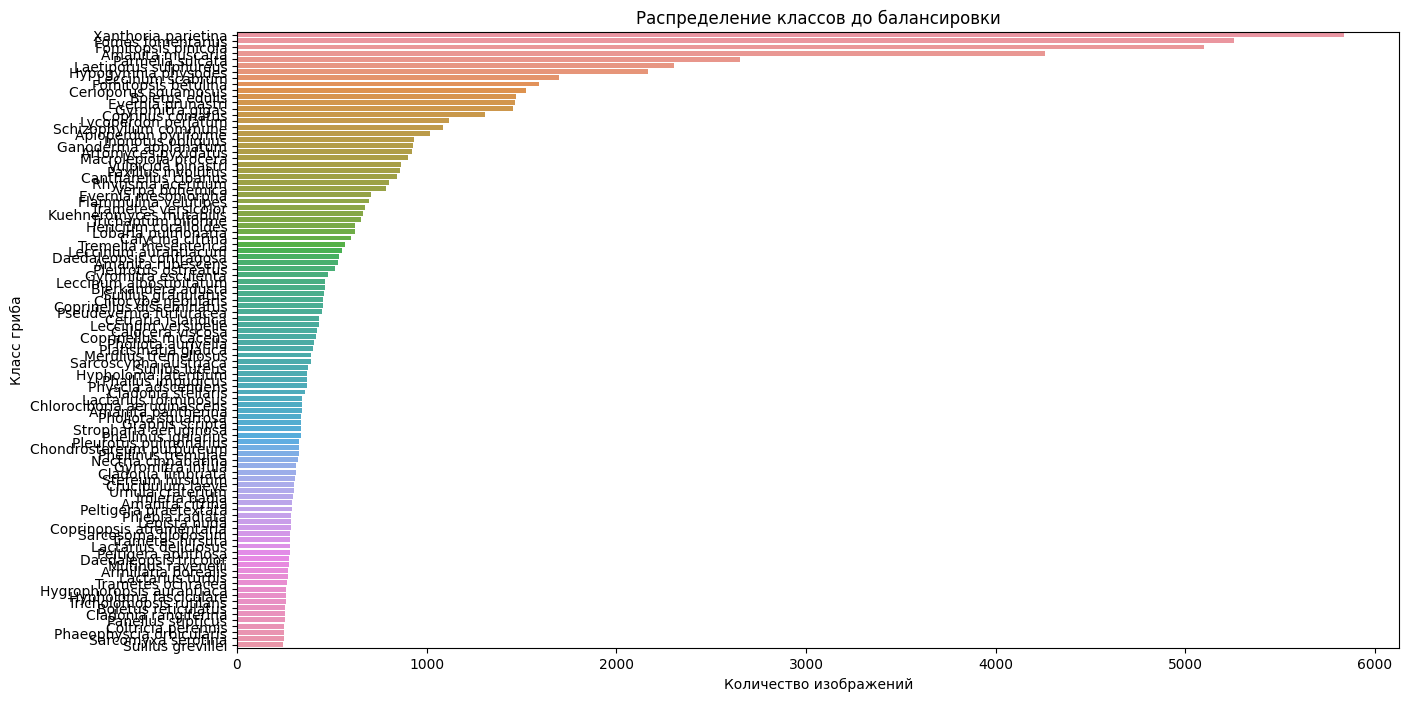

In [26]:
# 3. Распределение классов до балансировки


plt.figure(figsize=(15, 8))
sns.countplot(data=df, y='label', order=df['label'].value_counts().index)
plt.title('Распределение классов до балансировки')
plt.xlabel('Количество изображений')
plt.ylabel('Класс гриба')
plt.show()

In [27]:
# 4. Проблемы с несбалансированностью классов


class_dist = df['label'].value_counts(normalize=True)
print("\n4. Анализ баланса классов:")
print(f"Максимальная доля класса: {class_dist.max():.2f}")
print(f"Минимальная доля класса: {class_dist.min():.2f}")
print(f"Соотношение: {class_dist.max()/class_dist.min():.1f}:1")


4. Анализ баланса классов:
Максимальная доля класса: 0.08
Минимальная доля класса: 0.00
Соотношение: 23.8:1


In [28]:
# 5. Разрешение изображений
# Проверим несколько изображений


sample_images = df['image'].sample(10)
resolutions = []
for img_path in sample_images:
    try:
        with Image.open(img_path) as img:
            resolutions.append(img.size)
    except:
        continue

print(f"5. Примеры разрешений изображений: {resolutions[:10]}\n")

5. Примеры разрешений изображений: [(375, 500), (500, 333), (375, 500), (375, 500), (500, 375), (375, 500), (375, 500), (500, 333), (333, 500), (500, 333)]



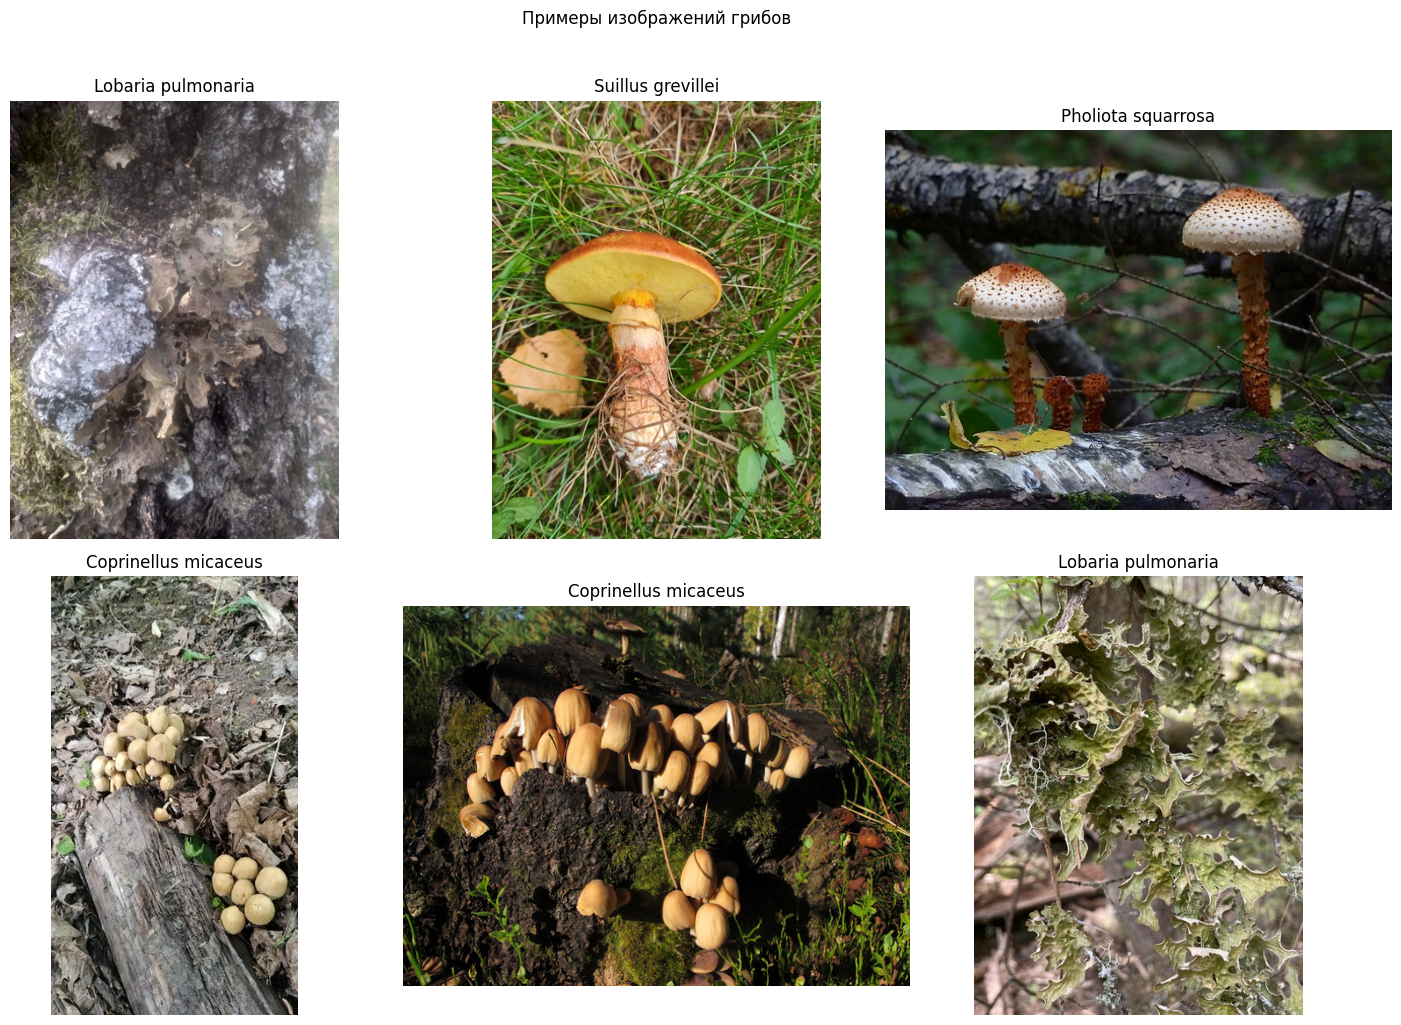

In [29]:
# 6. Анализ специфических особенностей грибов
# Визуализируем несколько примеров


fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, (idx, row) in enumerate(df.sample(6).iterrows()):
    ax = axes[i//3, i%3]
    try:
        img = Image.open(row['image'])
        ax.imshow(img)
        ax.set_title(row['label'])
        ax.axis('off')
    except:
        continue
plt.suptitle('Примеры изображений грибов', y=1.02)
plt.tight_layout()
plt.show()

# ViT

baseline с использованием предобученной модели google/vit-base-patch16-224-in21k

In [ ]:
#!pip install -U -q evaluate transformers datasets>=2.14.5 accelerate>=0.27 2>/dev/null

In [1]:
import warnings  # Модуль для обработки предупреждений
warnings.filterwarnings("ignore")  # Игнорировать предупреждения во время выполнения

from pathlib import Path
from tqdm import tqdm
import os

import gc  # Модуль для сборки мусора
import numpy as np  # Библиотека для численных операций
import pandas as pd  # Библиотека для работы с данными
import itertools  # Модуль для работы с итераторами
from collections import Counter  # Для подсчета элементов
import matplotlib.pyplot as plt  # Библиотека для визуализации данных
from sklearn.metrics import (  # Метрики оценки модели
    accuracy_score,  # Точность
    roc_auc_score,  # ROC AUC
    confusion_matrix,  # Матрица ошибок
    classification_report,  # Отчет классификации
    f1_score  # F1-мера
)

import accelerate # Ускорение вычислений
from datasets import Dataset, Image, ClassLabel  # Для работы с датасетами
from transformers import (  # Библиотека трансформеров
    TrainingArguments,  # Аргументы обучения
    Trainer,  # Тренер модели
    ViTImageProcessor,  # Процессор изображений
    ViTForImageClassification,  # Модель ViT
    DefaultDataCollator  # Коллатор данных
)

import torch  # PyTorch
from torch.utils.data import DataLoader, WeightedRandomSampler  # Загрузка данных
from torchvision.transforms import (  # Трансформации изображений
    CenterCrop,  # Центральное кадрирование
    Compose,  # Композиция трансформаций
    Normalize,  # Нормализация
    RandomRotation,  # Случайный поворот
    RandomResizedCrop,  # Случайное кадрирование
    RandomHorizontalFlip,  # Случайное отражение
    RandomAdjustSharpness,  # Настройка резкости
    Resize,  # Изменение размера
    ToTensor  # Преобразование в тензор
)

from PIL import ImageFile  # Для работы с изображениями

# Разрешить загрузку усеченных изображений
ImageFile.LOAD_TRUNCATED_IMAGES = True
from transformers import Trainer
from datasets import ClassLabel
from pathlib import Path
import pandas as pd

2025-05-10 09:09:43.884940: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746868184.119993      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746868184.189100      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## сбор датасета

In [2]:
# Классы для исключения
to_remove = {
    'Apioperdon pyriforme', 'Artomyces pyxidatus', 'Calycina citrina',
    'Evernia mesomorpha', 'Graphis scripta', 'Mutinus ravenelii',
    'Phaeophyscia orbicularis', 'Rhytisma acerinum', 'Sarcomyxa serotina',
    'Sarcosoma globosum', 'Urnula craterium', 'Verpa bohemica'
}

file_names = []
labels = []

for file in Path('/kaggle/input/mushroom-species/dataset/').glob('*/*.*'):
    label = file.parent.name  # Получаем метку из имени папки
    
    if label not in to_remove:  # Фильтрация ДО добавления в списки
        file_names.append(str(file))
        labels.append(label)

# Создаем DataFrame только с нужными данными
df = pd.DataFrame({"image": file_names, "label": labels})

print(f"Найдено изображений: {len(df)}")
print(f"Уникальные классы: {df['label'].nunique()}")

dataset = Dataset.from_pandas(df).cast_column("image", Image())

Найдено изображений: 70859
Уникальные классы: 88


## подготовка меток классов

In [8]:
labels_list = df['label'].unique()

labels_list = [i for i in labels_list if i not in to_remove]

# Создание словарей для соответствия меток и ID
label2id, id2label = dict(), dict()
for i, label in enumerate(labels_list):
    label2id[label] = i
    id2label[i] = label

In [9]:
# Создаем ClassLabel на основе всех меток
class_labels = ClassLabel(names=labels_list)

# Функция для преобразования меток
def map_label2id(example):
    example['label'] = class_labels.str2int(example['label'])
    return example

# Применяем преобразование
dataset = dataset.map(map_label2id, batched=False)  # batched=False для поштучной обработки

# Меняем тип столбца 'label' на ClassLabel
dataset = dataset.cast_column('label', class_labels)

Map:   0%|          | 0/70859 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/70859 [00:00<?, ? examples/s]

In [10]:
# разделяем данные
dataset = dataset.train_test_split(test_size=0.2, stratify_by_column="label")
train_data = dataset['train']
test_data = dataset['test']

## балансировка классов с помощью WeightedRandomSampler

In [11]:
# создаем семплер для train_data
labels = class_labels.str2int(train_data['label'])
class_counts = np.bincount(labels)
class_weights = 1. / class_counts
weights = class_weights[labels]

sampler = WeightedRandomSampler(
    weights=weights,
    num_samples=len(weights),
    replacement=True
)

## подготовка модели и процессора

In [12]:
# Загрузка предобученной модели
model_str = "google/vit-base-patch16-224-in21k"

# Получаем актуальное количество классов
num_classes = len(labels_list)  # Должно быть 88 в вашем случае

# Создаем корректные id2label и label2id
id2label = {i: label for i, label in enumerate(labels_list)}
label2id = {label: i for i, label in enumerate(labels_list)}

# Загружаем модель с правильными параметрами
processor = ViTImageProcessor.from_pretrained(model_str)
model = ViTForImageClassification.from_pretrained(
    model_str,
    num_labels=num_classes,  # Теперь 88 вместо 100
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True  # Важно для изменения числа классов
)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## трансформаций для изображений

In [13]:
# Параметры нормализации
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]
print("Размер изображения: ", size)

normalize = Normalize(mean=image_mean, std=image_std)

# Трансформации для обучения
_train_transforms = Compose([
    Resize((size, size)),
    RandomRotation(90),
    RandomAdjustSharpness(2),
    ToTensor(),
    normalize
])

# Трансформации для валидации
_val_transforms = Compose([
    Resize((size, size)),
    ToTensor(),
    normalize
])

Размер изображения:  224


In [14]:
# Функции трансформаций
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# Применение трансформаций
train_data.set_transform(train_transforms)
test_data.set_transform(val_transforms)

# Функция для создания батчей
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example['label'] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

# Инициализация модели
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))
model.config.id2label = id2label
model.config.label2id = label2id

print(f"Количество обучаемых параметров (млн): {model.num_parameters(only_trainable=True) / 1e6}")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Количество обучаемых параметров (млн): 85.866328


## настройка параметров и обучение модели

In [15]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predicted_labels = predictions.argmax(axis=1)
    acc = accuracy_score(labels, predicted_labels)
    return {"accuracy": acc}

# Настройки обучения
metric_name = "accuracy"
model_name = "mushrooms_image_detection"
num_train_epochs = 1

args = TrainingArguments(
    output_dir=model_name,
    logging_dir='./logs',
    eval_strategy="epoch",  # Изменено с evaluation_strategy на eval_strategy
    learning_rate=5e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    num_train_epochs=num_train_epochs,
    weight_decay=0.02,
    warmup_steps=50,
    remove_unused_columns=False,
    save_strategy='epoch',
    load_best_model_at_end=True,
    save_total_limit=1,
    report_to="none",
    dataloader_drop_last=True,
    dataloader_pin_memory=True,
    dataloader_num_workers=2
)

In [16]:
# Инициализация Trainer

# 1. Создаем кастомный класс Trainer с поддержкой семплера
class CustomTrainer(Trainer):
    def get_train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.args.per_device_train_batch_size,
            sampler=sampler,
            collate_fn=collate_fn,
            num_workers=self.args.dataloader_num_workers,
            drop_last=self.args.dataloader_drop_last,
            pin_memory=self.args.dataloader_pin_memory
        )

# 2. Инициализация кастомного Trainer'а
trainer = CustomTrainer(
    model=model,
    args=args,
    train_dataset=train_data,
    eval_dataset=test_data,
    compute_metrics=compute_metrics,
    tokenizer=processor,
    data_collator=collate_fn  # Обратите внимание на правильное название параметра
)

In [17]:
# Оценка модели до обучения
trainer.evaluate()

{'eval_loss': 4.491344928741455,
 'eval_accuracy': 0.009533898305084746,
 'eval_runtime': 107.1455,
 'eval_samples_per_second': 132.269,
 'eval_steps_per_second': 8.269}

In [18]:
# Обучение модели
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.536700,1.418264,0.815749


TrainOutput(global_step=1771, training_loss=2.2203202336471275, metrics={'train_runtime': 1414.6555, 'train_samples_per_second': 40.071, 'train_steps_per_second': 1.252, 'total_flos': 4.395011060374438e+18, 'train_loss': 2.2203202336471275, 'epoch': 1.0})

In [41]:
# Оценка модели после обучения
trainer.evaluate()

{'eval_loss': 1.4387460947036743,
 'eval_accuracy': 0.8038135593220339,
 'eval_runtime': 111.9422,
 'eval_samples_per_second': 126.601,
 'eval_steps_per_second': 7.915,
 'epoch': 1.0}

## предсказания и оценка

{'test_loss': 1.4178876876831055, 'test_accuracy': 0.81045197740113, 'test_runtime': 115.4286, 'test_samples_per_second': 122.777, 'test_steps_per_second': 7.676}
Точность: 0.8105
F1-мера: 0.7698


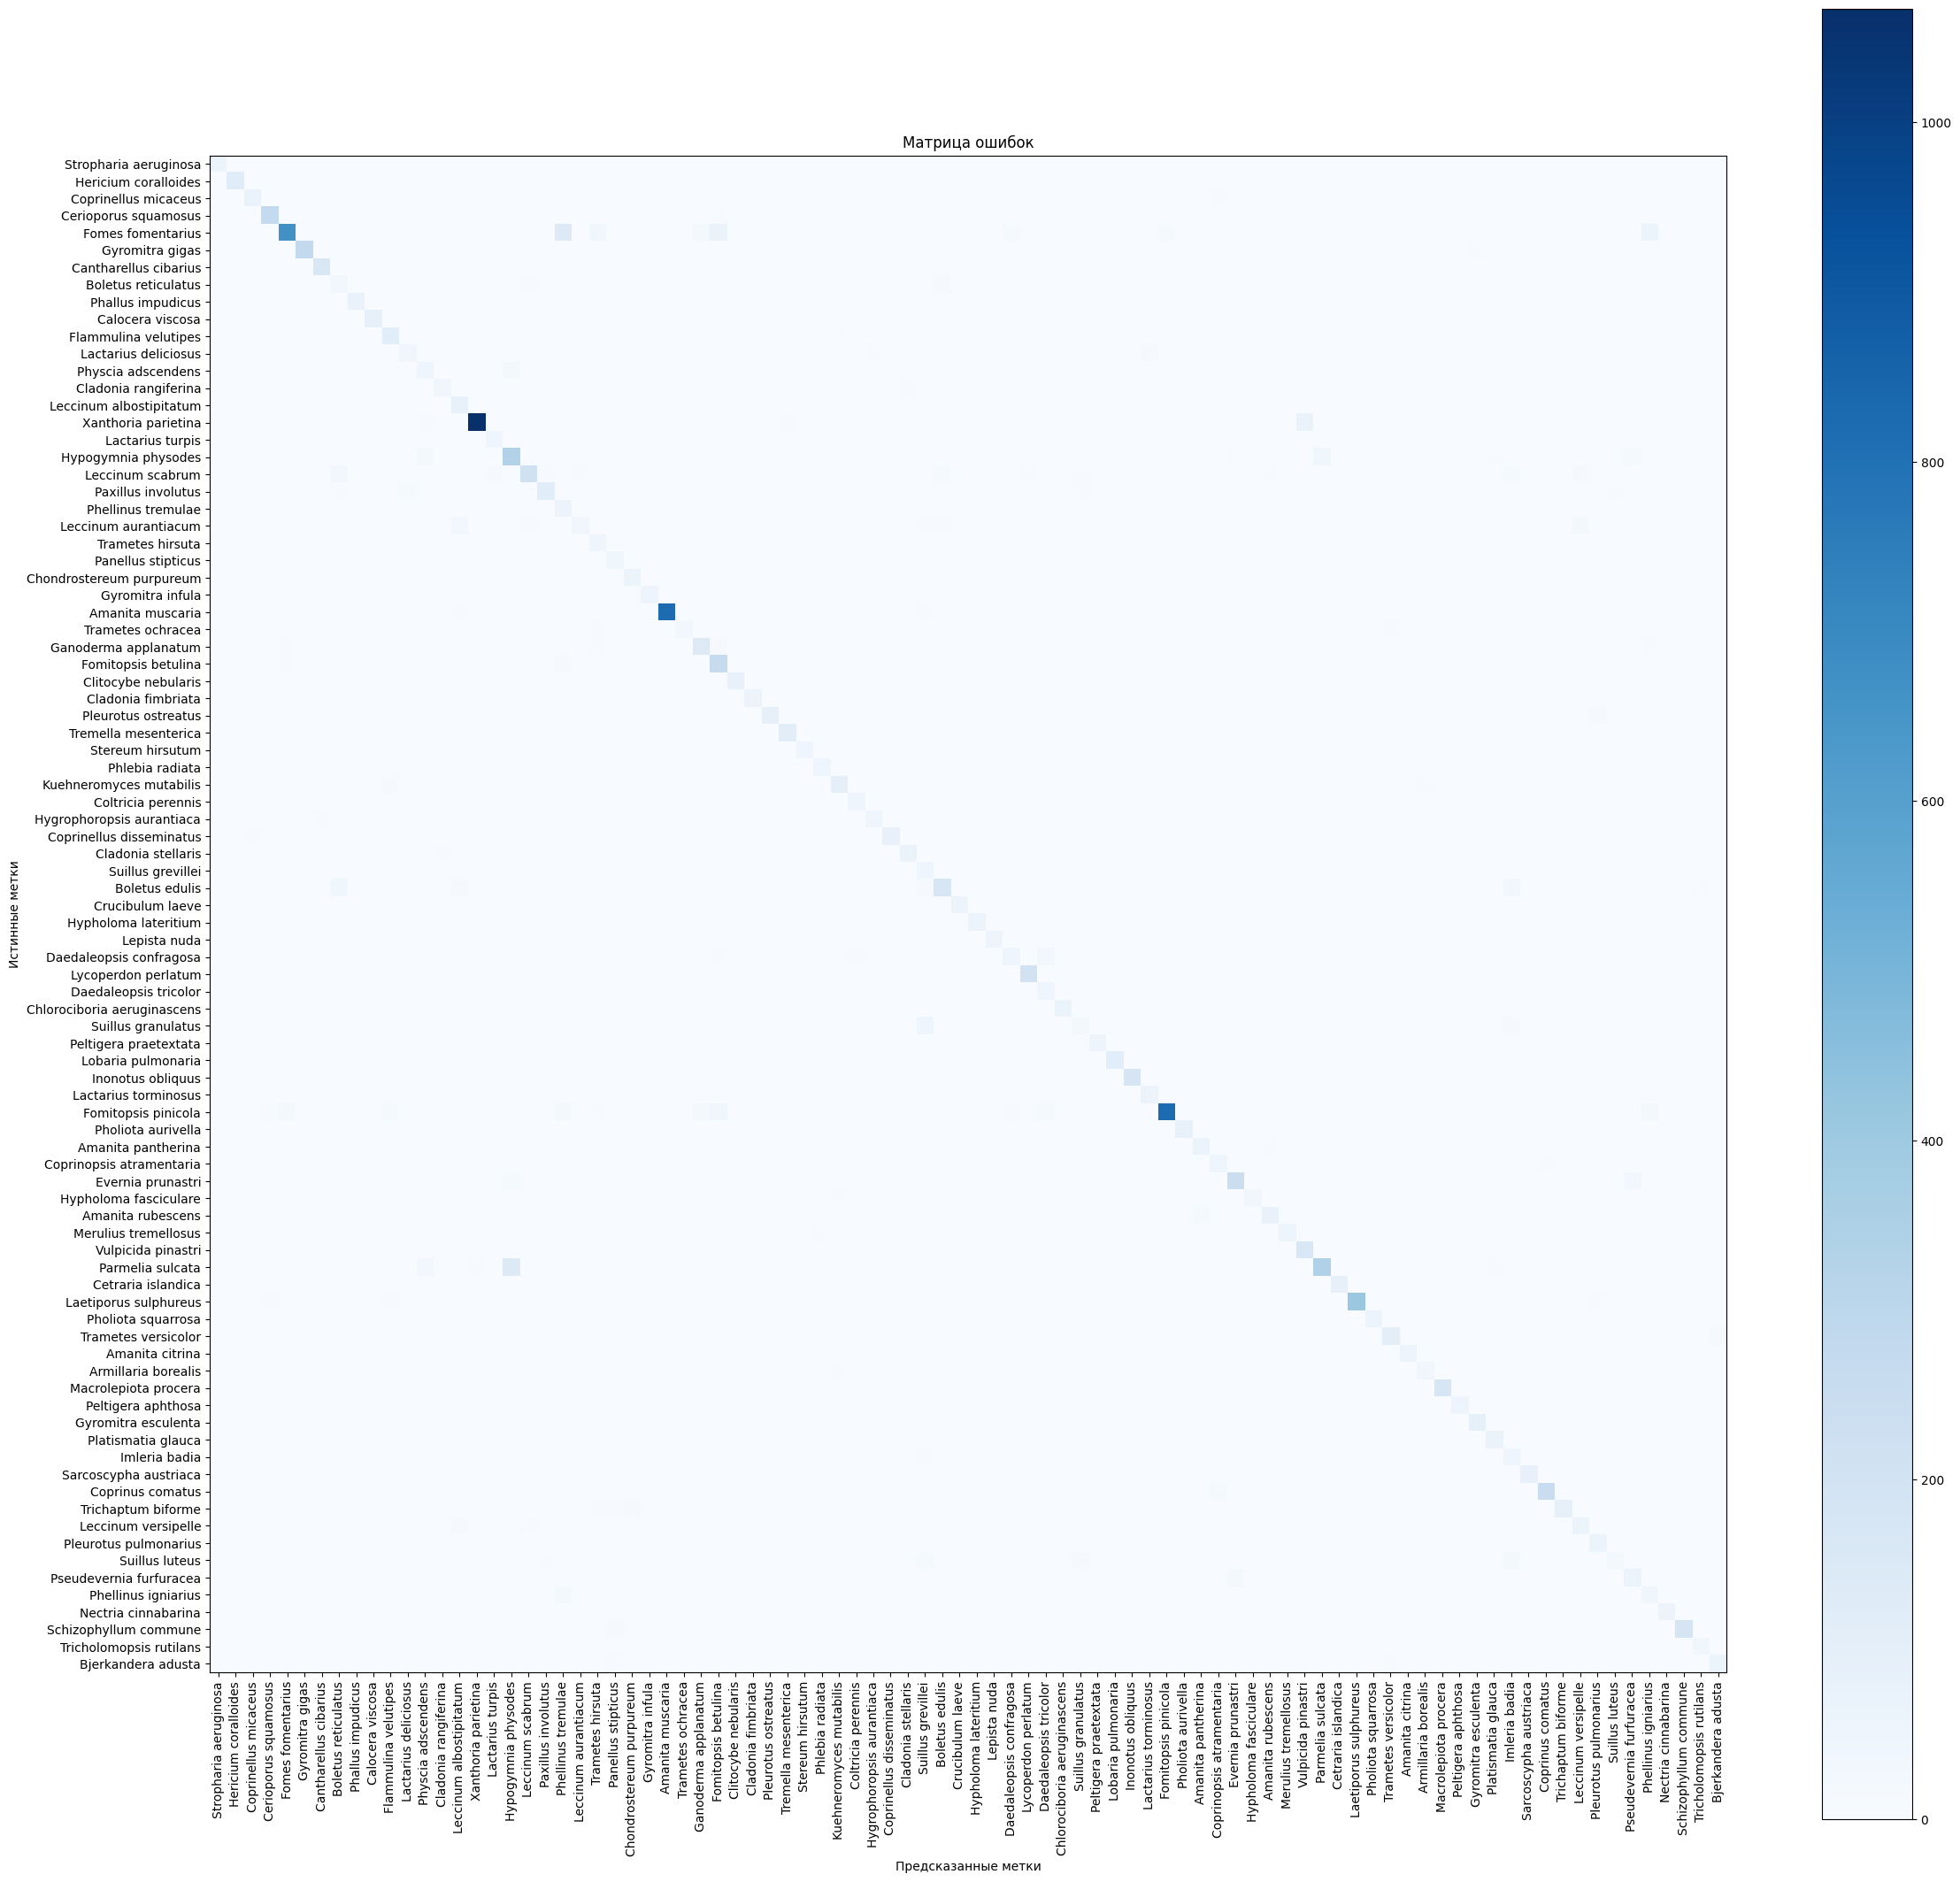


Отчет классификации:

                             precision    recall  f1-score   support

      Stropharia aeruginosa     0.9559    0.9701    0.9630        67
       Hericium coralloides     0.9760    0.9839    0.9799       124
       Coprinellus micaceus     0.7907    0.8193    0.8047        83
       Cerioporus squamosus     0.9125    0.8885    0.9003       305
          Fomes fomentarius     0.9358    0.6390    0.7595      1050
            Gyromitra gigas     0.9719    0.9552    0.9635       290
      Cantharellus cibarius     0.8939    0.9524    0.9222       168
        Boletus reticulatus     0.2632    0.5882    0.3636        51
          Phallus impudicus     0.9114    0.9730    0.9412        74
           Calocera viscosa     0.9551    1.0000    0.9770        85
       Flammulina velutipes     0.6994    0.8201    0.7550       139
       Lactarius deliciosus     0.5606    0.6607    0.6066        56
         Physcia adscendens     0.4386    0.6757    0.5319        74
       Cla

In [20]:
outputs = trainer.predict(test_data)
print(outputs.metrics)

# Извлечение истинных и предсказанных меток
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

# Функция для визуализации матрицы ошибок
def plot_confusion_matrix(cm, classes, title='Матрица ошибок', cmap=plt.cm.Blues, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if len(labels_list) <= 50:
        fmt = '.0f'
        thresh = cm.max() / 2.0
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Истинные метки')
    plt.xlabel('Предсказанные метки')
    plt.tight_layout()
    plt.show()

# Расчет метрик
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Точность: {accuracy:.4f}")
print(f"F1-мера: {f1:.4f}")

# Визуализация матрицы ошибок (если классов не слишком много)
if len(labels_list) <= 120:
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, labels_list, figsize=(24, 22))

# Отчет классификации
print("\nОтчет классификации:\n")
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

## сохранение модели после обучения

In [21]:
# лучше сделать через ONNX, чтобы потом использовать где угодно, но возникает ошибка с версиями на kaggle

from transformers import ViTForImageClassification, ViTImageProcessor
import torch
import json

# Путь для сохранения
save_path = "./mushrooms_model_baseline"

# 1. Сохраняем модель и процессор
model.save_pretrained(save_path)
processor.save_pretrained(save_path)

# 2. Сохраняем метаданные (для удобства)
metadata = {
    "id2label": id2label,
    "label2id": label2id,
    "class_names": labels_list,
    "image_size": size
}

with open(f"{save_path}/metadata.json", "w") as f:
    json.dump(metadata, f, indent=4)

print(f"Модель сохранена в {save_path}")

Модель сохранена в ./mushrooms_model_baseline


# полный код для запроса в gpt

In [ ]:
import warnings  # Модуль для обработки предупреждений
warnings.filterwarnings("ignore")  # Игнорировать предупреждения во время выполнения

from pathlib import Path
from tqdm import tqdm
import os

import gc  # Модуль для сборки мусора
import numpy as np  # Библиотека для численных операций
import pandas as pd  # Библиотека для работы с данными
import itertools  # Модуль для работы с итераторами
from collections import Counter  # Для подсчета элементов
import matplotlib.pyplot as plt  # Библиотека для визуализации данных
from sklearn.metrics import (  # Метрики оценки модели
    accuracy_score,  # Точность
    roc_auc_score,  # ROC AUC
    confusion_matrix,  # Матрица ошибок
    classification_report,  # Отчет классификации
    f1_score  # F1-мера
)

import accelerate # Ускорение вычислений
from datasets import Dataset, Image, ClassLabel  # Для работы с датасетами
from transformers import (  # Библиотека трансформеров
    TrainingArguments,  # Аргументы обучения
    Trainer,  # Тренер модели
    ViTImageProcessor,  # Процессор изображений
    ViTForImageClassification,  # Модель ViT
    DefaultDataCollator  # Коллатор данных
)

import torch  # PyTorch
from torch.utils.data import DataLoader, WeightedRandomSampler  # Загрузка данных
from torchvision.transforms import (  # Трансформации изображений
    CenterCrop,  # Центральное кадрирование
    Compose,  # Композиция трансформаций
    Normalize,  # Нормализация
    RandomRotation,  # Случайный поворот
    RandomResizedCrop,  # Случайное кадрирование
    RandomHorizontalFlip,  # Случайное отражение
    RandomAdjustSharpness,  # Настройка резкости
    Resize,  # Изменение размера
    ToTensor  # Преобразование в тензор
)

from PIL import ImageFile  # Для работы с изображениями

# Разрешить загрузку усеченных изображений
ImageFile.LOAD_TRUNCATED_IMAGES = True
from transformers import Trainer
from datasets import ClassLabel
from pathlib import Path
import pandas as pd
# Классы для исключения
to_remove = {
    'Apioperdon pyriforme', 'Artomyces pyxidatus', 'Calycina citrina',
    'Evernia mesomorpha', 'Graphis scripta', 'Mutinus ravenelii',
    'Phaeophyscia orbicularis', 'Rhytisma acerinum', 'Sarcomyxa serotina',
    'Sarcosoma globosum', 'Urnula craterium', 'Verpa bohemica'
}

file_names = []
labels = []

for file in Path('/kaggle/input/mushroom-species/dataset/').glob('*/*.*'):
    label = file.parent.name  # Получаем метку из имени папки
    
    if label not in to_remove:  # Фильтрация ДО добавления в списки
        file_names.append(str(file))
        labels.append(label)

# Создаем DataFrame только с нужными данными
df = pd.DataFrame({"image": file_names, "label": labels})

print(f"Найдено изображений: {len(df)}")
print(f"Уникальные классы: {df['label'].nunique()}")

dataset = Dataset.from_pandas(df).cast_column("image", Image())
